In [1]:
import numpy as np
import pandas as pd
from ase.io import read, write
from ase import units
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm


plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=15, titlesize=15)    # x and y axes
plt.rc('xtick', labelsize=15)    # Major Ticks
plt.rc('ytick', labelsize=15)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


In [2]:
pred_step = 4
input = 8

#The function takes arrays of forces and returns a VAR OLS model
#_____Inputs______
# main - 1D np array with the time series which the model fits to.
# secondary - 2D np array with the secondary time series used to predict the main time series
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a OLS model that uses the main and secondary time series to predict the main time series. In order to predict t+2 of the main timeseries,
# t+1 of both main and secondary time series must be known. If the values of the secondary time series is not known this can be done by also creating models
# for the secondary time series and use those to predict the value at t+1
def create_VAR_OLS_model(main, secondary, order=2):
    input = len(main)-order
    num_secondaries = secondary.shape[0]
    X = np.zeros([input,order*(num_secondaries+1)+1])
    for i in range(order):
        X[:,i*(num_secondaries+1)] = main[i:input+i]
        for j in range(num_secondaries):
            X[:,i*(num_secondaries+1)+j+1] = secondary[j,i:input+i]
    X[:,-1] = np.ones(len(main)-order)
    return sm.OLS(main[order:], X)

# Returns 3 fitted models from create_VAR_OLS_model to create 3 models to respectively predict the forces in x, y, and z direction for an atom in a molecule.
# Uses L2 regularized fitting.
#_____Inputs______
# forces - 2D np array with the three force time series for the atom chosen. Has the shape [N, 3] where N is the number of input points in the model.
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns 3 fitted VAR OLS which can be used to predict future points in the time series. t+1 must be predicted for all three time series before t+2 can be predicted.
def create_atom_OLS_model(forces, order=2):
    model_x = create_VAR_OLS_model(forces[0,:], np.array([forces[1,:],forces[2,:]]), order=order).fit_regularized(method="elastic_net", L1_wt=0)
    model_y = create_VAR_OLS_model(forces[1,:], np.array([forces[0,:],forces[2,:]]), order=order).fit_regularized(method="elastic_net", L1_wt=0)
    model_z = create_VAR_OLS_model(forces[2,:], np.array([forces[0,:],forces[1,:]]), order=order).fit_regularized(method="elastic_net", L1_wt=0)
    return model_x, model_y, model_z

# Function which predicts the forces on the atoms in a molecule for a certain number of time steps
#_____Inputs______
# file - String with the name of the xyz file containing information on the molecule
# input - Positive integer with the number of data points used as input in training the OLS VAR models
# pred_step - Positive integer which decides the number of time steps predicted by the OLS VAR models
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a 3D np array with the predicted forces. The array as the following shape [N, 3, p], with N being the number of atoms in the molecule
# and p being the number of time steps predicted
def predict_forces(mol, input=input, pred_step=pred_step, order=2):
    n_atoms = mol[0].get_global_number_of_atoms()
    predicted_forces = np.zeros((n_atoms, 3, pred_step))
    forces = np.zeros((n_atoms, 3, input))

    for i in range(len(mol)):
        forces[:,:,i] = mol[i].get_forces()
    for i in range(n_atoms):
    
        model_x, model_y, model_z = create_atom_OLS_model(forces[i,:,:], order=order)
        forecast_forces = np.zeros((3, pred_step+order))
        forecast_forces[:,:order] = forces[i,:,-order:]
        for j in range(pred_step):
            input_x = np.array([forecast_forces[0,j], forecast_forces[1,j], forecast_forces[2,j], forecast_forces[0,j+1], forecast_forces[1,j+1], forecast_forces[2,j+1], 1])
            input_y = np.array([forecast_forces[1,j], forecast_forces[0,j], forecast_forces[2,j], forecast_forces[1,j+1], forecast_forces[0,j+1], forecast_forces[2,j+1], 1])
            input_z = np.array([forecast_forces[2,j], forecast_forces[0,j], forecast_forces[1,j], forecast_forces[2,j+1], forecast_forces[0,j+1], forecast_forces[1,j+1], 1])
            forecast_forces[0,order+j] = model_x.predict(input_x)
            forecast_forces[1,order+j] = model_y.predict(input_y)
            forecast_forces[2,order+j] = model_z.predict(input_z)
        predicted_forces[i,:,:] = forecast_forces[:,2:]
        
    return predicted_forces



# Evaluating model with input and pred

In [3]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':')
input = 6
pred_step = 6
dt = 0.5*units.fs
mae = []
k=0
while k < len(mol)-input-pred_step:
    predicted_forces = predict_forces(mol[k:k+input], input=input, pred_step=pred_step)
    temp_mol = mol[k+input-1]
    #Repurposing the step function from ASE velverlet
    for i in range(pred_step):
        #Get masses for the atoms in the molecule
        masses = temp_mol.get_masses()[:, np.newaxis]

        #Get the forces, momenta, and positions for the current step
        #forces = mol[i].get_forces()
        force_step = predicted_forces[:,:,i] 
        p = temp_mol.get_momenta()
        r = temp_mol.get_positions()
        
        #Calculate new momenta and positions
        p += 0.5 * dt * force_step
        temp_mol.set_positions(r + dt * p / masses)
        error = temp_mol.get_positions()-mol[k+input+i].get_positions()
        mae.append(np.abs(error))
        #Was in ase.step. Unsure if needed
        if temp_mol.constraints:
            p = (temp_mol.get_positions() - r) * masses / dt

        #Momenta needs to be stored before possible calculations of forces
        temp_mol.set_momenta(p, apply_constraint=False)

        #Forces for next step is found either using predicted forces or gpaw calculator
        if i<pred_step-1:
            force_step = predicted_forces[:,:,i+1]
        

        #Calculate and set momenta for the next step
        temp_mol.set_momenta(temp_mol.get_momenta() + 0.5 * dt * force_step)
    k+=input+pred_step


mae = 0.0034808967986673114 +- 0.0003381398710607643
[0.00015765408233400096, 0.0006370334030666873, 0.0015010367330952064, 0.0029442822952334058, 0.005480016196342803, 0.010165358081931768]
[4.267897119712412e-08, 7.267057529411723e-07, 4.694159455294081e-06, 2.793539985803558e-05, 0.00020545969695787635, 0.0017179627821865746]


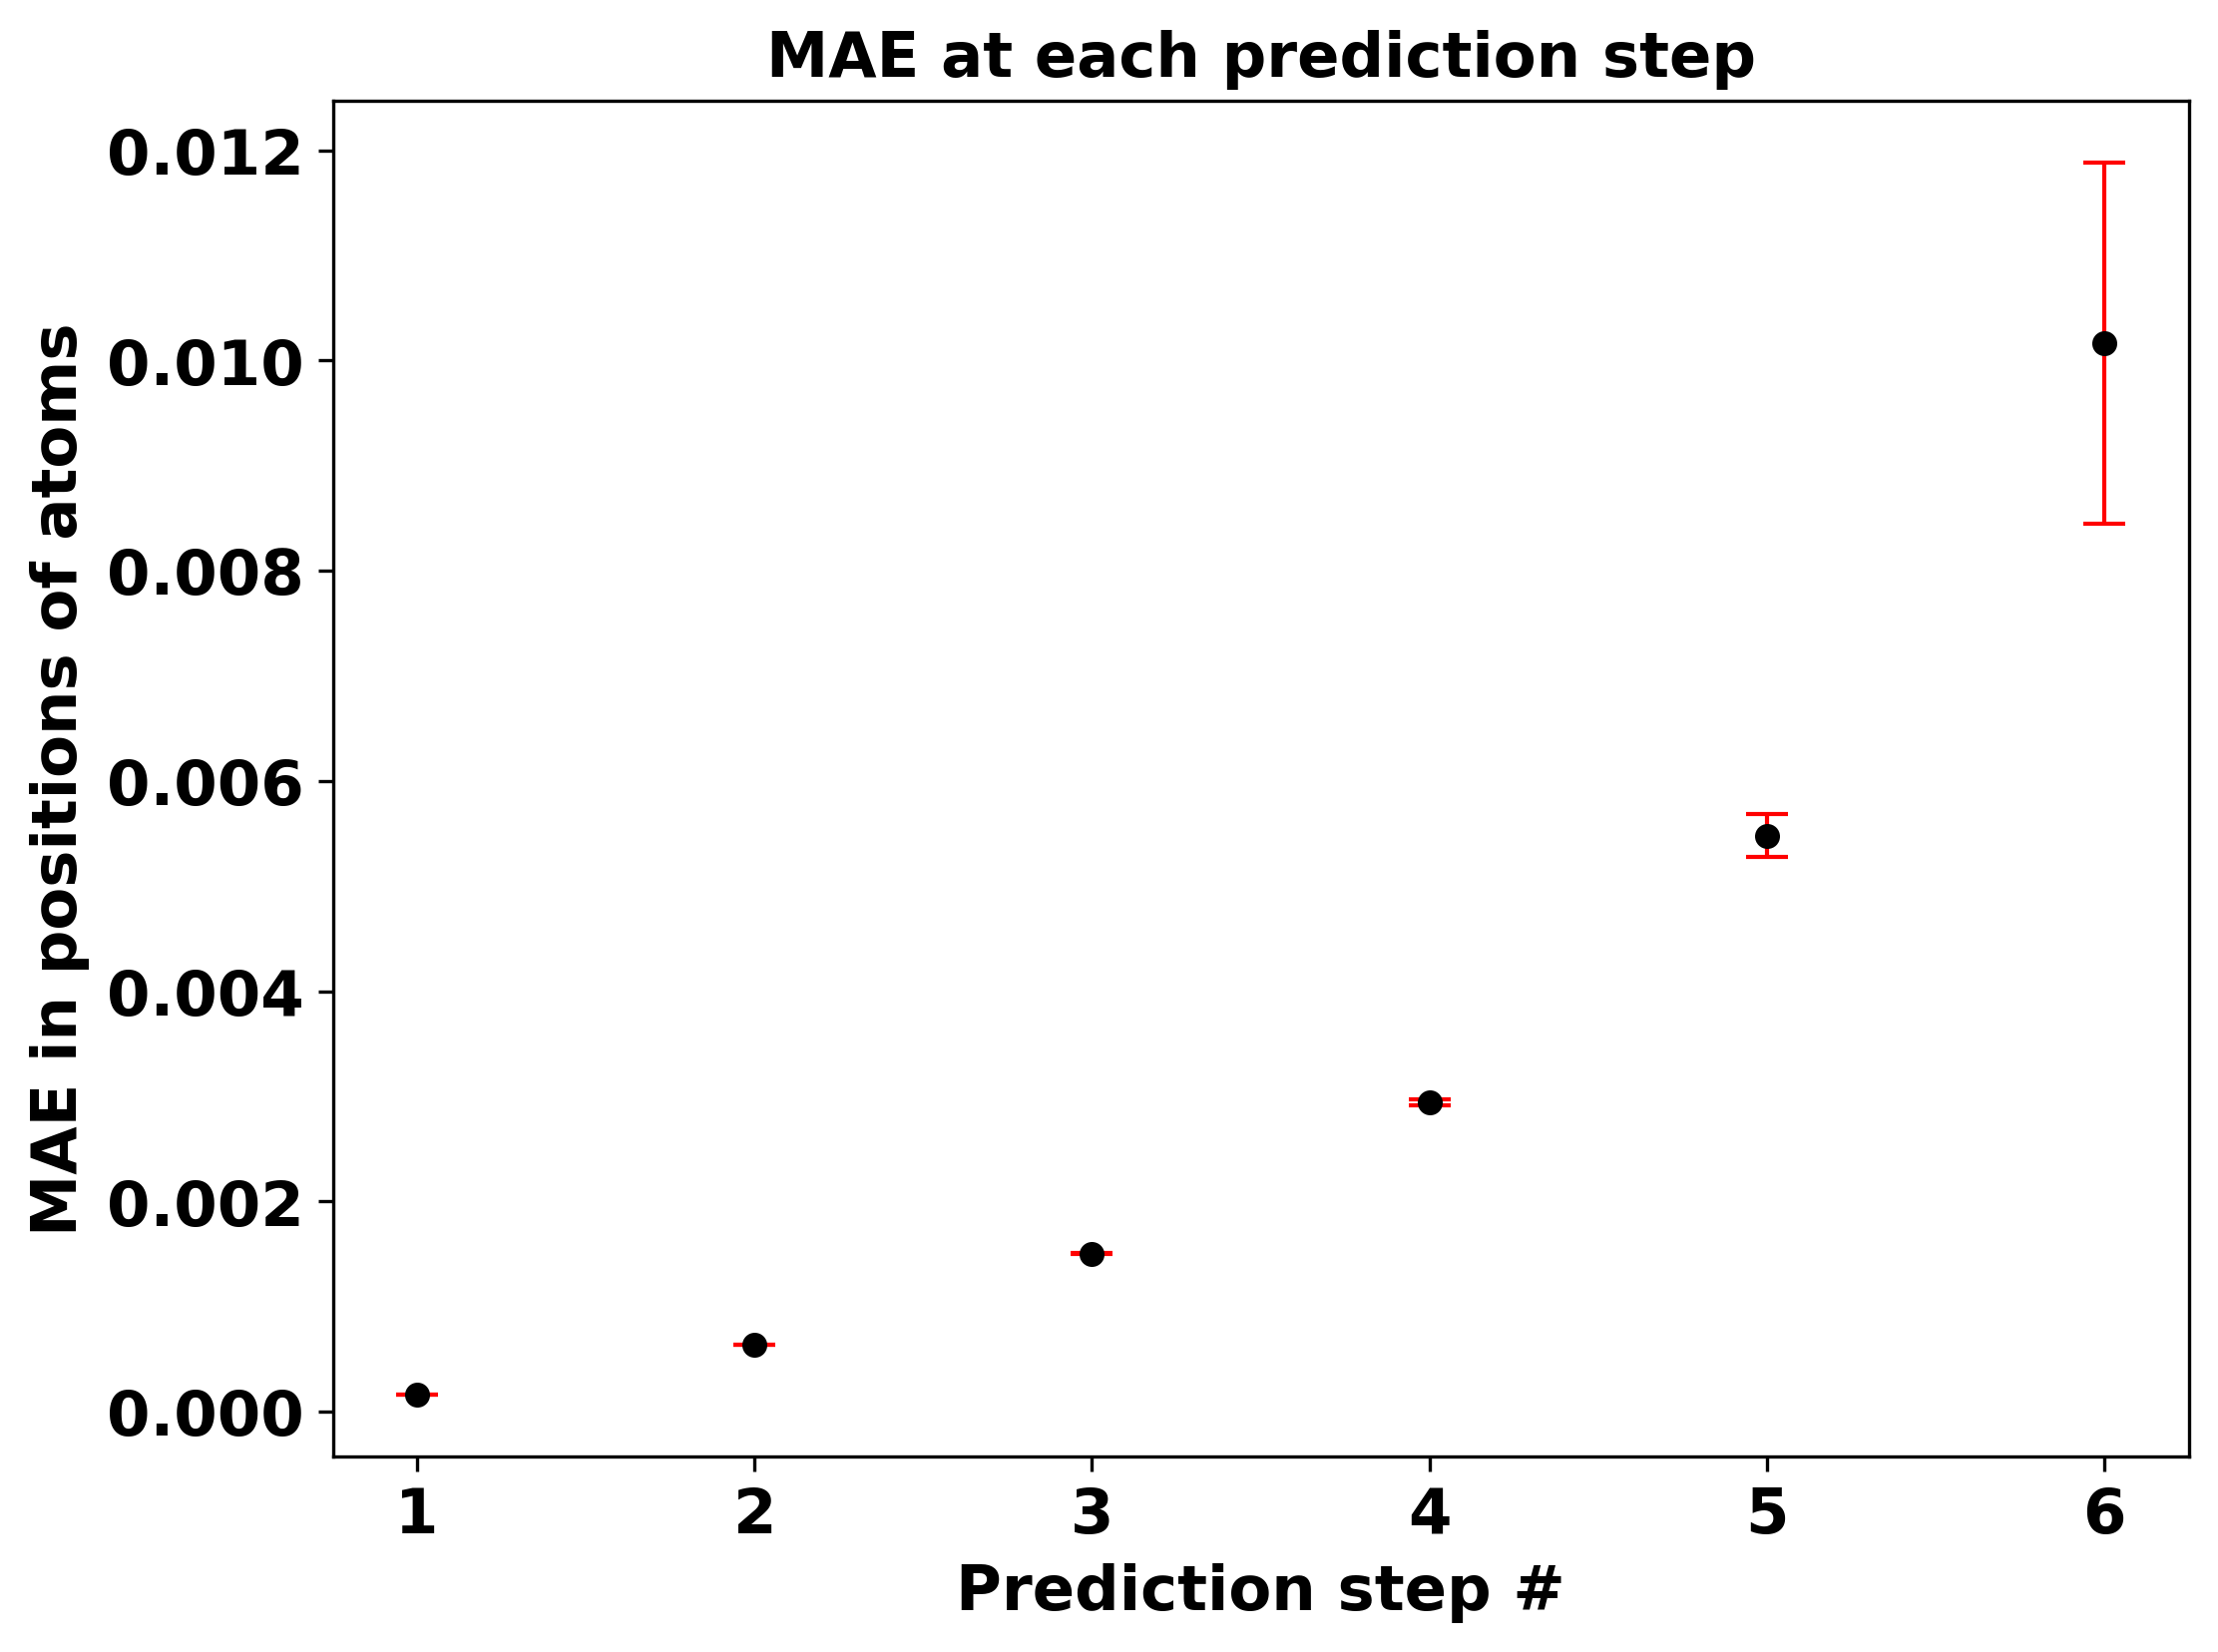

In [4]:
mae = np.asarray(mae)
mae_steps = []
var_steps = []
for i in range(pred_step):
    mae_steps.append(np.mean(mae[i::pred_step,:,:]))
    var_steps.append(np.var(mae[i::pred_step,:,:]))
print("mae =",np.mean(mae), "+-", np.var(mae))

print(mae_steps)
print(var_steps)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(range(1, pred_step+1), mae_steps, yerr=np.array(var_steps), fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(0, 0.29)
ax.set_ylabel("MAE in positions of atoms", fontweight="bold")
ax.set_xlabel("Prediction step #", fontweight="bold")
ax.set_title("MAE at each prediction step", fontweight="bold")
ax.minorticks_off()

166.0
mae = 0.0034808967986673114 +- 0.0003381398710607643
[0.00015765408233400096, 0.00039734374270034413, 0.0007652414061652982, 0.0013100016284323254, 0.002144004542014421, 0.0034808967986673122]


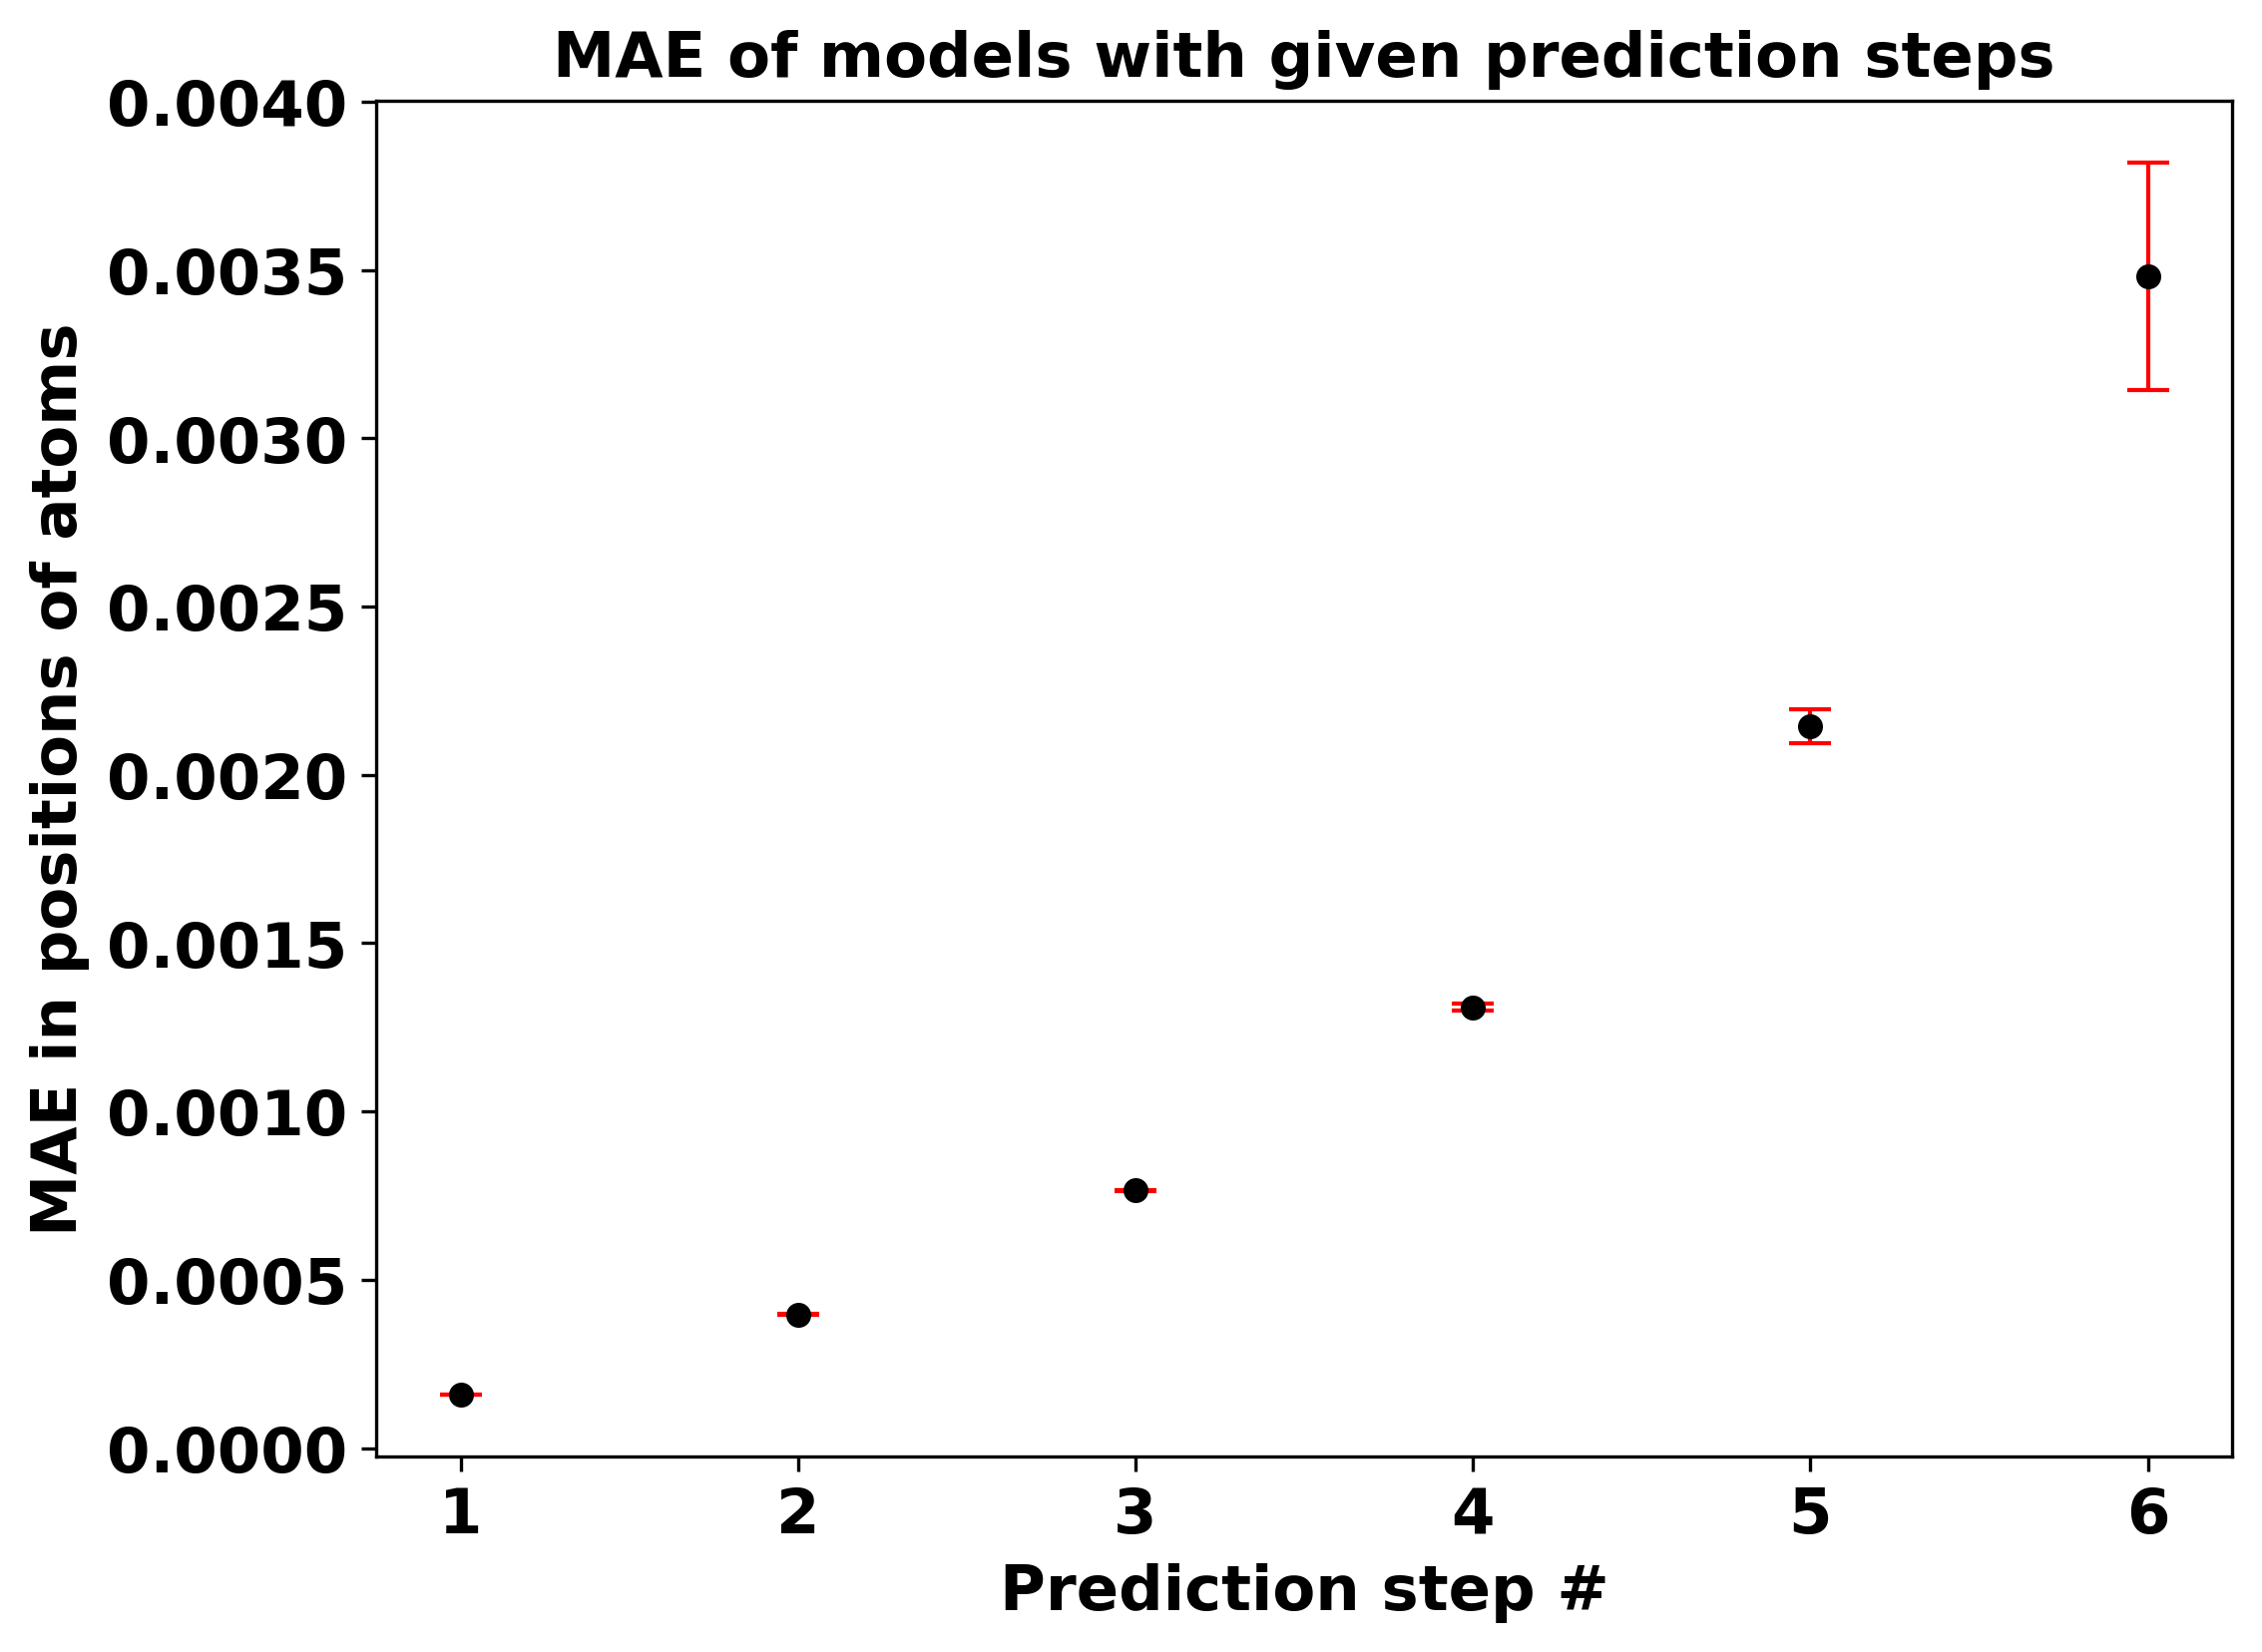

In [5]:
print(len(mae)/pred_step)
mae_steps = np.ones([pred_step, int(len(mae)/pred_step), 9, 3])
mae_model = []
var_model = []


for i in range(pred_step):
    mae_steps[i,:,:,:] = mae[i::pred_step,:,:]

for i in range(pred_step):
    mae_model.append(np.mean(mae_steps[:i+1,:]))
    var_model.append(np.var(mae_steps[:i+1,:]))
print("mae =",np.mean(mae), "+-", np.var(mae))
print(mae_model)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(range(1, pred_step+1), mae_model, yerr=np.array(var_model), fmt='.k',  ecolor='r', elinewidth=1, capsize=5, capthick=1, ms=10)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(0, 0.29)
ax.set_ylabel("MAE in positions of atoms", fontweight="bold")
ax.set_xlabel("Prediction step #", fontweight="bold")
ax.set_title("MAE of models with given prediction steps", fontweight="bold")
ax.minorticks_off()

# Average difference in positions between timesteps

0.007303043855816797 4.946534206599226e-05
0.007303043855816797 4.946534206599226e-05


(0.0, 200.0)

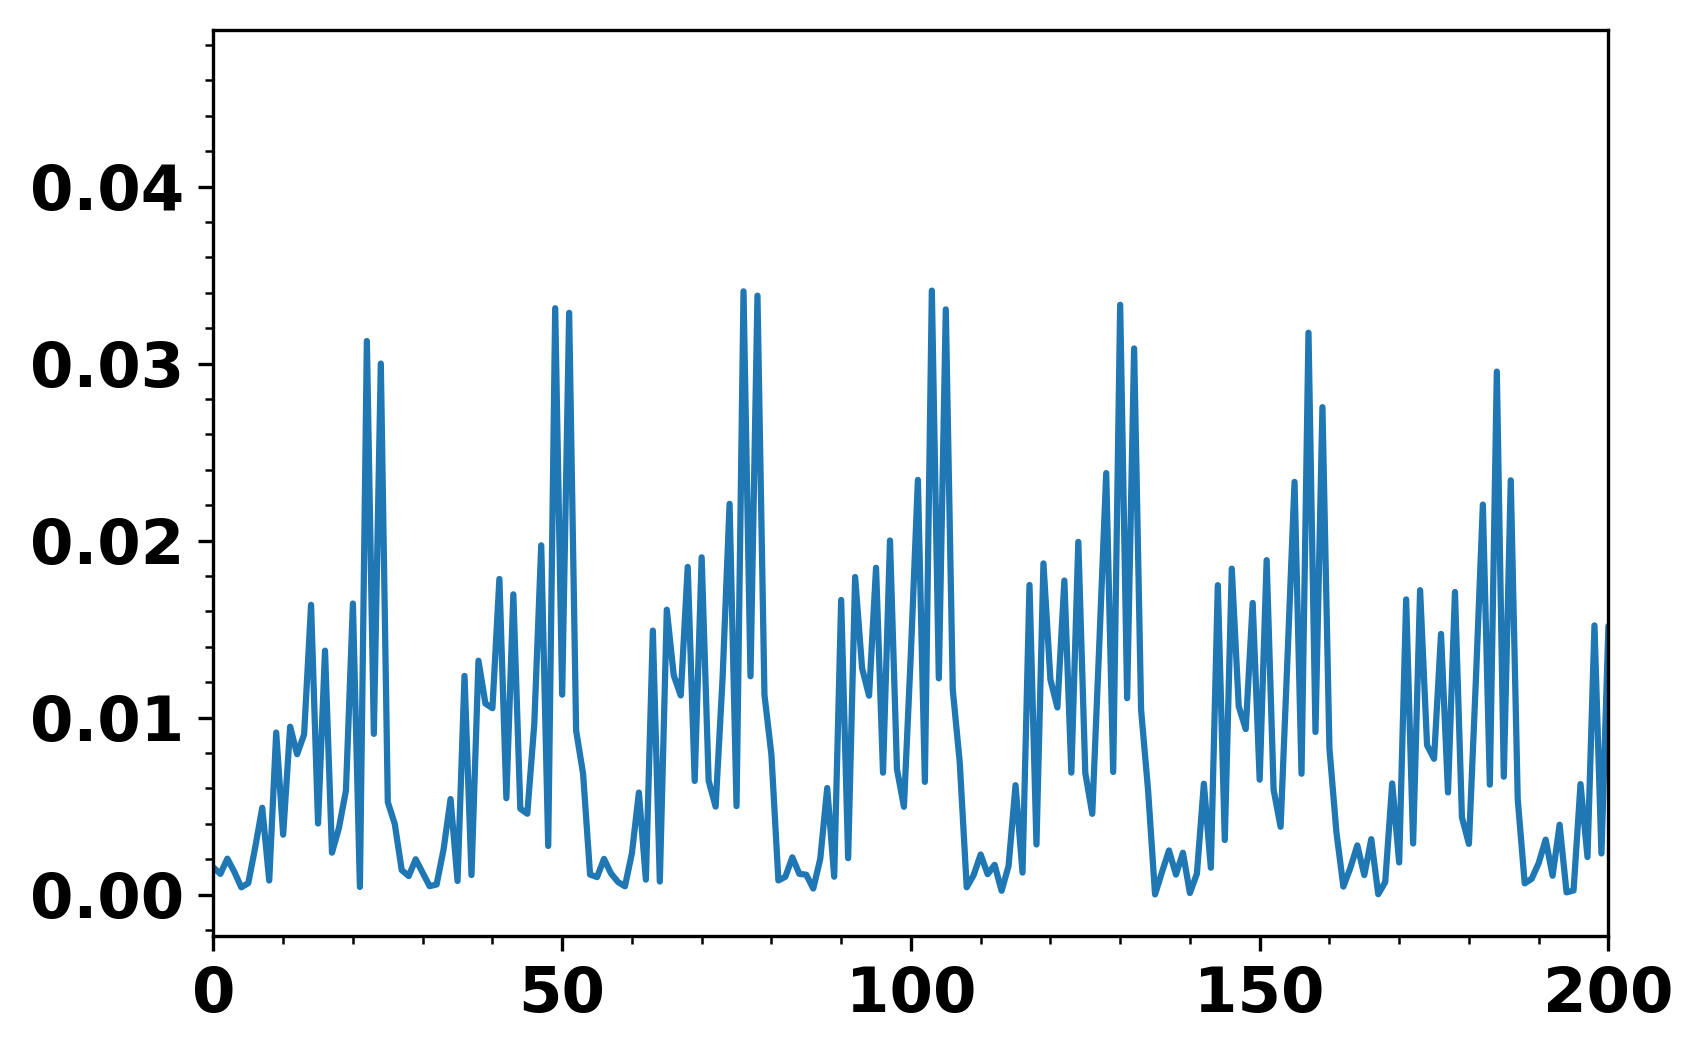

In [26]:
mol = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':')

av_position_difference = []

for i in range(len(mol)-1):
    av_position_difference.append(((np.abs(mol[i+1].get_positions()-mol[i].get_positions()))))
pos_dif = np.asanyarray(av_position_difference).flatten()
print(np.mean(av_position_difference), np.var(av_position_difference))
print(np.mean(pos_dif), np.var(pos_dif))
plt.plot(range(len(pos_dif)), pos_dif)
plt.xlim(0, 200)
#9.886145254608742e-07